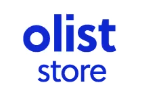

<h1><center> NOTEBOOK SIMULATION

# SOMMAIRE  <a id="0"></a>

I.  [Importation des bibliothèques et données](#1)<br>
II. [Clustering des clients dont l'ancienneté est supérieure à un an](#2)<br>
III. [Calcul et Evolution de l'ARI dans le temps](#3)<br>
IV. [Simulations par période de maintenance](#4)<br>


# I. Importation des bibliothèques et données  <a id="1"></a>


In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
from itertools import product #efficient looping
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import plotly.express as px

#librairies for preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler

#librairies for clustering
from sklearn.cluster import KMeans

#librairies evaluation
from sklearn.metrics.cluster import adjusted_rand_score


In [2]:
#import file
customers=pd.read_csv('clients.csv')

In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         96096 non-null  object 
 1   nb_orders                  96096 non-null  int64  
 2   mean_spent_per_order       96096 non-null  float64
 3   mean_items_per_order       96096 non-null  float64
 4   mean_unique_cat_per_order  96096 non-null  float64
 5   num_review_comments        96096 non-null  int64  
 6   mean_score                 96096 non-null  float64
 7   recency                    96096 non-null  int64  
 8   age                        96096 non-null  int64  
 9   year                       96096 non-null  int64  
 10  SP                         96096 non-null  int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 8.1+ MB


# II. Clutering des clients dont l'ancienneté est de plus d'un an  <a id="2"></a>


Dans un premier temps nous allons scinder le data frame en deux et analyser le clustering des clients âgés de plus de un an et vérifier si nous avons un clustering similaire à celui sur toute la base.

In [4]:
age_threshold=customers['age'].min()+365

In [5]:
customers_old=customers.loc[customers['age']>=age_threshold].copy()

In [6]:
#ajustons la récence 
customers_old.loc[:,'recency']=customers_old.loc[:,'recency'].copy()-365

In [7]:
#récupérons les features
customers_features=customers_old.iloc[:,1:8]

Nous effectuons un clustering sur les anciens clients 

In [8]:
scaler=RobustScaler(unit_variance=True)

In [9]:
scaler.fit(customers_features)

RobustScaler(unit_variance=True)

In [10]:
#scaling anciens clients
customers_scaled_old=scaler.transform(customers_features)

In [11]:
kmeans=KMeans(4, init="k-means++" )
kmeans.fit(customers_scaled_old)

KMeans(n_clusters=4)

Analyse des centroïdes

In [12]:
centroides=scaler.inverse_transform(kmeans.cluster_centers_)

In [13]:
#creation d'un dataframe avec les coordonnées des centroïdes
centroides_df=pd.DataFrame(centroides)
centroides_df.columns=customers.columns[1:8]

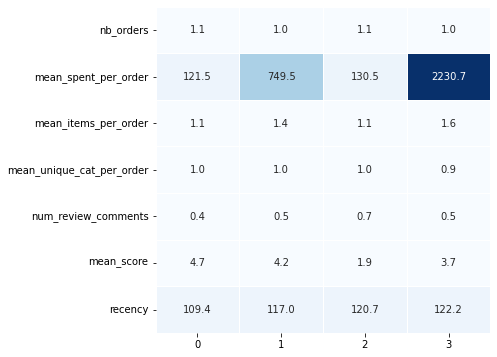

In [14]:
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(centroides_df.T, annot=True, linewidths=.5, ax=ax, fmt='.1f', cbar=False, cmap='Blues')
plt.show()

# III. Calcul et évolution de l' ARI dans le temps  <a id="3"></a>


Nous allons considérer la population des clients anciens de plus d'un an comme la base clients de départ et nous allons considérer l' évolution de la base client après une période d'un mois, deux mois...jusqu'à 12 mois.

Après chaque période nous allons 
- (1) nous servir du clustering de l'ancienne base pour prédir le clustering de la nouvelle base client
- (2) effectuer un clustering de la nouvelle base client directement
- (3) calculer l' ARI à partir des label prédit (1) et les labels obtenus directement(2)



In [15]:
#liste des ARI
ari_indexes=[]
cust_new=[] #nombre de clients dans la nouvelle base

for i in range(1,12):
    #base incluant les nouveaux clients des i derniers mois
    customers_new=customers.loc[customers['age']>=(age_threshold-30*i)].copy()
    customers_new.loc[:,'recency']=customers_new.loc[:,'recency'].copy()-365+30*i #ajustement récence
    cust_new.append(len(customers_new))
    
#1. segmentation à partir de la segmentation des anciens clients 

    #scaling nouveaux clients
    customers_scaled_new=scaler.transform(customers_new.iloc[:,1:8])
    #segmentation incluant les nouveaux clients
    new_labels=kmeans.predict(customers_scaled_new)
    
#2. segmentation directe de la nouvelle base
    customers_scaled_new2=RobustScaler(unit_variance=True).fit_transform(customers_new.iloc[:,1:8])
    kmeans=KMeans(4, init="k-means++" )
    kmeans.fit(customers_scaled_new2)
    true_labels=pd.Series(kmeans.labels_)
    
    #calcul ARI
    ari=adjusted_rand_score(true_labels, new_labels)
    ari_indexes.append(ari)

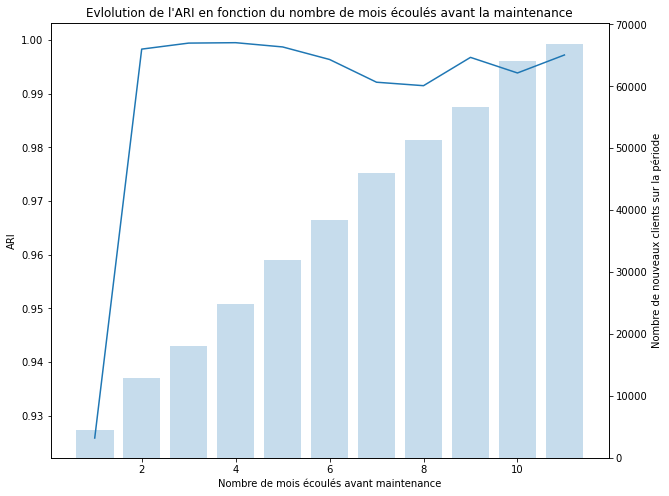

In [16]:
# plotting results
fig, ax1= plt.subplots( figsize=(10,8))
ax1.plot(range(1,12),ari_indexes)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
cust_diff=np.array(cust_new)-len(customers_old)
ax2.bar(range(1,12),cust_diff, alpha=0.25)
ax1.set_title(f"Evlolution de l'ARI en fonction du nombre de mois écoulés avant la maintenance")
ax1.set_xlabel('Nombre de mois écoulés avant maintenance')
ax1.set_ylabel('ARI')
ax2.set_ylabel('Nombre de nouveaux clients sur la période')

plt.show()

# IV. Simulations par fréquence de maintenance  <a id="4"></a>


Nous allons maintenant simuler des scénarios de maintenances périodiques.
Nous supposons cette fois que les bases des anciens et nouveaux clients évoluent en fonction de la périodicité de la maintenance.

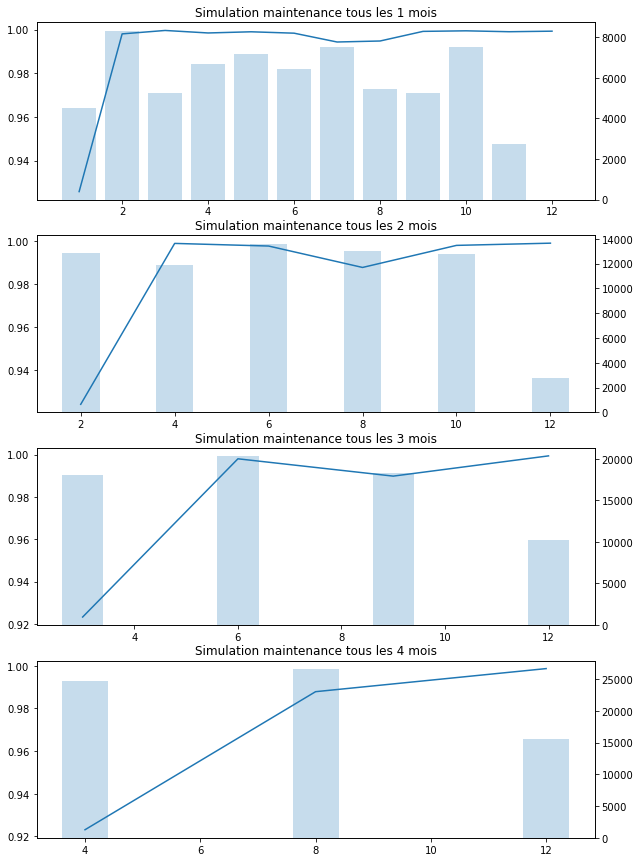

In [17]:
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,1, figsize=(10,15))


for i, ax in zip([1,2,3,4],[ax1,ax2,ax3,ax4]):
    
    age_threshold=customers['age'].min()+365
    ajust_recency=365
    #liste des ARI
    ari_indexes=[]
    cust_new=[] #nombre de clients dans la nouvelle base
    cust_old=[] #nombre de clients dans l'ancienne base
    for j in range(0,int(12/i)):
    
        #base anciens clients
        customers_old=customers.loc[customers['age']>=age_threshold].copy()
        #ajustons la récence 
        customers_old.loc[:,'recency']=customers_old.loc[:,'recency'].copy()-ajust_recency
        cust_old.append(len(customers_old))

        #récupérons les features
        customers_features=customers_old.iloc[:,1:8]

        scaler=RobustScaler()
        #scaling anciens clients
        scaler.fit(customers_features)
        customers_scaled_old=scaler.transform(customers_features)

        # segmentation anciens clients
        kmeans=KMeans(4, init="k-means++" )
        kmeans.fit(customers_scaled_old)


        #base incluant les nouveaux clients dU derniers mois
        customers_new=customers.loc[customers['age']>=(age_threshold-30*i)].copy()
        customers_new.loc[:,'recency']=customers_new.loc[:,'recency'].copy()-ajust_recency+30*i #ajustement récence
        cust_new.append(len(customers_new))

    #1. segmentation à partir de la segmentation de l'ancienne base clients    
        
        #scaling nouveaux clients
        customers_scaled_new=scaler.transform(customers_new.iloc[:,1:8])
        #segmentation incluant les nouveaux clients
        new_labels=kmeans.predict(customers_scaled_new)

    #2. segmentation directe de la nouvelle base clients
        customers_scaled_new2=RobustScaler().fit_transform(customers_new.iloc[:,1:8])
        kmeans=KMeans(4, init="k-means++" )
        kmeans.fit(customers_scaled_new2)
        true_labels=pd.Series(kmeans.labels_)

        #calcul ARI
        ari=adjusted_rand_score(true_labels, new_labels)
        ari_indexes.append(ari)

        age_threshold=age_threshold-30*i
        ajust_recency=ajust_recency+30*i
        
    ax.plot(range((0+i),(12+i),i),ari_indexes)
    axb = ax.twinx()  # instantiate a second axes that shares the same x-axis
    cust_diff=np.array(cust_new)-np.array(cust_old)
    axb.bar(range((0+i),(12+i),i),cust_diff, alpha=0.25)
    ax.set_title(f'Simulation maintenance tous les {i} mois')
    
plt.show()